In [23]:
from dwave.system import DWaveSampler, EmbeddingComposite
from dimod import BinaryQuadraticModel
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from tabulate import tabulate
from dwave.cloud import Client

In [386]:
#DWAVE_API_TOKEN = 'DEV-9e6ad578ad1d5c10a1365ce2b037e444b5e8b230'

#with Client.from_config(token=DWAVE_API_TOKEN) as client:
#    solvers = client.get_solvers()

#    for solver in solvers:
#        print("Solver Name:", solver.name)
#        print("Is Online:", solver.online)
#        print("Solver ID:", solver.id)
#        print()

In [408]:
#constructing our objective function
Nlim = 4# number of platns to be assigned - increase the Nlim for more number of locations

def create_random_matrix(n):
    return np.random.randint(1, 51, size=(n, n))
    
C = create_random_matrix(Nlim)  #cost of transporting one unit of energy from location i to location j
#np.fill_diagonal(C, 0)

In [409]:
print(C)

[[34 11  3 30]
 [17 43 20 33]
 [30 31 21 15]
 [ 9 23 15 11]]


In [410]:
bqm = BinaryQuadraticModel('BINARY')  #Creating a BQM model
#Koopmans-Beckmann formulation

for i in range(Nlim):
    for j in range(Nlim):      
        bqm.add_variable(f'x_{i}_{j}', C[i][j]) 

bqm.add_linear_equality_constraint([(f"x_{i}_{j}", 1) for j in range(Nlim) for i in range(Nlim)], lagrange_multiplier=10, constant=-Nlim)
# Row Uniqueness Constraint
for i in range(Nlim):
   bqm.add_linear_equality_constraint([(f"x_{i}_{j}", 1) for j in range(Nlim)], lagrange_multiplier=10, constant=-1)

#Column Uniqueness Constraint
for j in range(Nlim):
    bqm.add_linear_equality_constraint([(f"x_{i}_{j}", 1) for i in range(Nlim)], lagrange_multiplier=10, constant=-1)

In [411]:
print(bqm)

BinaryQuadraticModel({'x_0_0': -56.0, 'x_0_1': -79.0, 'x_0_2': -87.0, 'x_0_3': -60.0, 'x_1_0': -73.0, 'x_1_1': -47.0, 'x_1_2': -70.0, 'x_1_3': -57.0, 'x_2_0': -60.0, 'x_2_1': -59.0, 'x_2_2': -69.0, 'x_2_3': -75.0, 'x_3_0': -81.0, 'x_3_1': -67.0, 'x_3_2': -75.0, 'x_3_3': -79.0}, {('x_0_1', 'x_0_0'): 40.0, ('x_0_2', 'x_0_0'): 40.0, ('x_0_2', 'x_0_1'): 40.0, ('x_0_3', 'x_0_0'): 40.0, ('x_0_3', 'x_0_1'): 40.0, ('x_0_3', 'x_0_2'): 40.0, ('x_1_0', 'x_0_0'): 40.0, ('x_1_0', 'x_0_1'): 20.0, ('x_1_0', 'x_0_2'): 20.0, ('x_1_0', 'x_0_3'): 20.0, ('x_1_1', 'x_0_0'): 20.0, ('x_1_1', 'x_0_1'): 40.0, ('x_1_1', 'x_0_2'): 20.0, ('x_1_1', 'x_0_3'): 20.0, ('x_1_1', 'x_1_0'): 40.0, ('x_1_2', 'x_0_0'): 20.0, ('x_1_2', 'x_0_1'): 20.0, ('x_1_2', 'x_0_2'): 40.0, ('x_1_2', 'x_0_3'): 20.0, ('x_1_2', 'x_1_0'): 40.0, ('x_1_2', 'x_1_1'): 40.0, ('x_1_3', 'x_0_0'): 20.0, ('x_1_3', 'x_0_1'): 20.0, ('x_1_3', 'x_0_2'): 20.0, ('x_1_3', 'x_0_3'): 40.0, ('x_1_3', 'x_1_0'): 40.0, ('x_1_3', 'x_1_1'): 40.0, ('x_1_3', 'x_1_2')

In [412]:
qubo = BinaryQuadraticModel.to_qubo(bqm)
qubo_matrix = qubo[0]

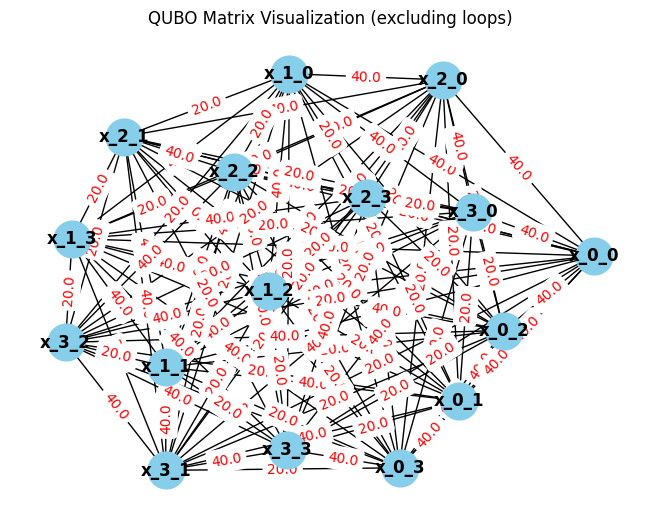

In [413]:
def visualize_qubo(qubo_dict):
    G = nx.Graph()

    variables = set()
    for edge in qubo_dict.keys():
        variables.add(edge[0])
        variables.add(edge[1])

    for variable in variables:
        G.add_node(variable)

    for edge, weight in qubo_dict.items():
        if edge[0] != edge[1]:
            G.add_edge(edge[0], edge[1], weight=weight)

    pos = nx.spring_layout(G)
    labels = {variable: variable for variable in variables}
    edge_labels = {(edge[0], edge[1]): weight for edge, weight in qubo_dict.items() if edge[0] != edge[1]}

    nx.draw(G, pos, with_labels=True, labels=labels, font_weight='bold', node_color='skyblue', node_size=700)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    plt.title("QUBO Matrix Visualization (excluding loops)")
    plt.show()

visualize_qubo(qubo_matrix)

In [414]:
sampler = EmbeddingComposite(DWaveSampler(solver='', token='DEV-9e6ad578ad1d5c10a1365ce2b037e444b5e8b230'))
sampleset = sampler.sample_qubo(qubo_matrix, num_reads=1000)

In [415]:
min_energy = float('inf')
min_sample = None

lowest_energy_solution = sampleset.first.sample
lowest_energy = sampleset.first.energy

print("Lowest Energy Solution:", lowest_energy_solution)
print("Energy:", lowest_energy)

Lowest Energy Solution: {'x_0_0': 0, 'x_0_1': 1, 'x_0_2': 0, 'x_0_3': 0, 'x_1_0': 0, 'x_1_1': 0, 'x_1_2': 1, 'x_1_3': 0, 'x_2_0': 0, 'x_2_1': 0, 'x_2_2': 0, 'x_2_3': 1, 'x_3_0': 1, 'x_3_1': 0, 'x_3_2': 0, 'x_3_3': 0}
Energy: -185.0


In [416]:
solution = sampleset.first.sample

indices = [(int(var[2]), int(var[4])) for var, value in solution.items() if value == 1]

table = tabulate(indices, headers=['Plant (p)', 'Location (i)'], tablefmt='grid')

print("Solution Table:")
print(table)

Solution Table:
+-------------+----------------+
|   Plant (p) |   Location (i) |
+=============+================+
|           0 |              1 |
+-------------+----------------+
|           1 |              2 |
+-------------+----------------+
|           2 |              3 |
+-------------+----------------+
|           3 |              0 |
+-------------+----------------+
